[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/connorcassedy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/connorcassedy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Logistic Regression Confusion Matrix:
[[10947   191   125]
 [  297   844   167]
 [   90    39  1585]]

K-Nearest Neighbors Confusion Matrix:
[[9670  152 1441]
 [ 542  280  486]
 [ 286   21 1407]]

Naive Bayes Confusion Matrix:
[[11208    53     2]
 [ 1073   232     3]
 [ 1571    72    71]]


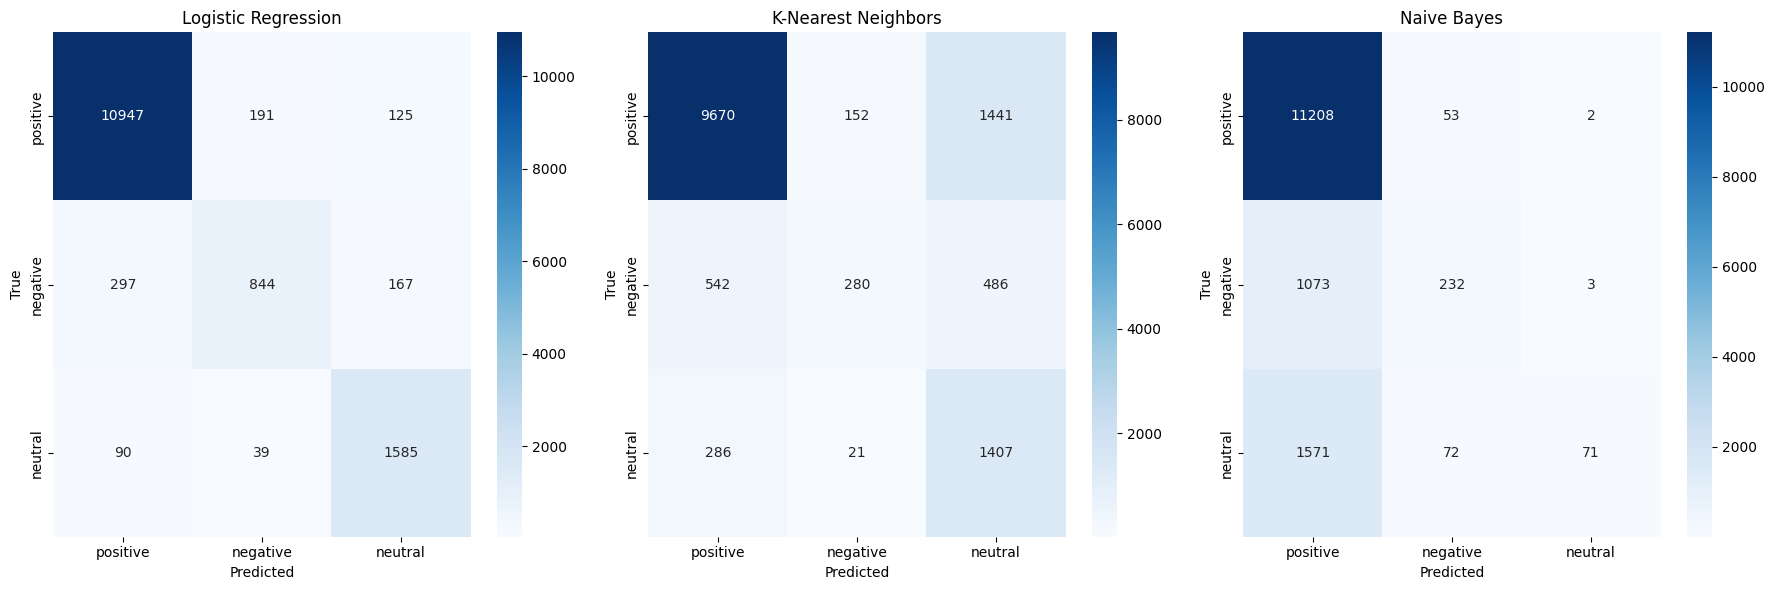

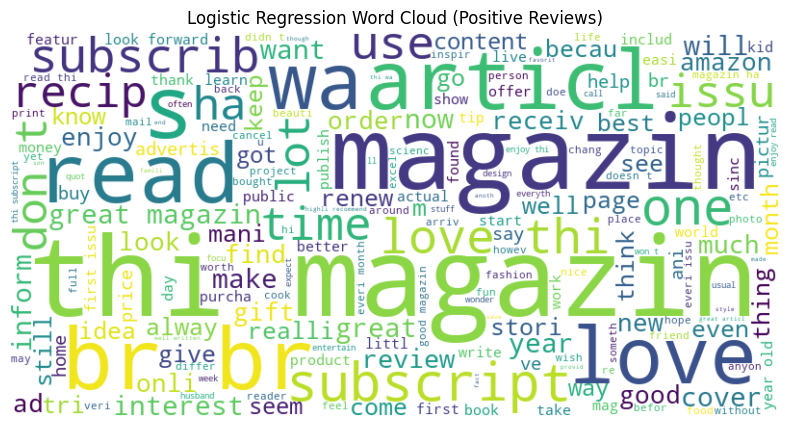

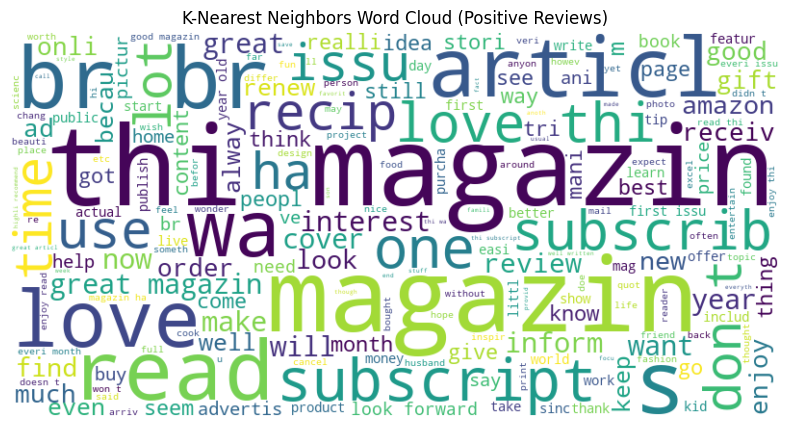

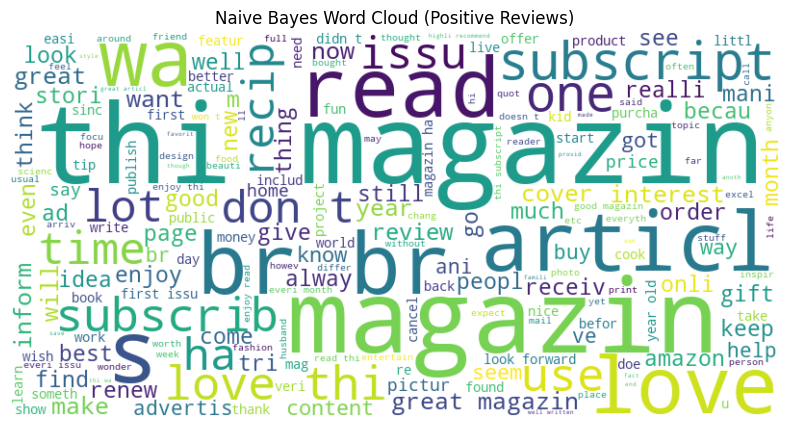


Logistic Regression Metrics:
Accuracy: 0.94
Precision: 0.87
Recall: 0.85
F1 Score: 0.85

K-Nearest Neighbors Metrics:
Accuracy: 0.80
Precision: 0.65
Recall: 0.63
F1 Score: 0.59

Naive Bayes Metrics:
Accuracy: 0.81
Precision: 0.80
Recall: 0.40
F1 Score: 0.42


In [11]:
import re
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')

def clean_text(text):
    # Remove special characters, URLs, and mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[^\s]+', '', text)  # Remove mentions
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters except whitespace
    # Convert to lowercase
    text = text.lower()
    return text

def tokenize_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens

def normalize_text(tokens):
    # Initialize Porter Stemmer
    porter = PorterStemmer()
    # Apply stemming
    normalized_tokens = [porter.stem(token) for token in tokens]
    return normalized_tokens

def filter_entries(entry):
    # Check if the rating is within the range of 1.0 to 5.0
    if not (1.0 <= entry['rating'] <= 5.0):
        return False
    
    # Check if the title and text body review are not empty
    if not entry['title'] or not entry['text']:
        return False
    
    # Remove unnecessary fields
    entry.pop('images', None)
    entry.pop('timestamp', None)
    entry.pop('verified_purchase', None)
    entry.pop('helpful_vote', None)
    
    return True

def classify_sentiment(sentiment_score):
    if sentiment_score > 0.05:
        return 'positive'
    elif sentiment_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Load JSONL file
with open('Magazine_Subscriptions.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Clean, tokenize, normalize text, and analyze sentiment in each entry
all_tokens = []
sentiment_labels = []
for entry in data:
    cleaned_text = clean_text(entry['text'])
    tokens = tokenize_text(cleaned_text)
    normalized_tokens = normalize_text(tokens)
    entry['text'] = ' '.join(normalized_tokens)
    all_tokens.extend(normalized_tokens)
    # Analyze sentiment
    sentiment_score = sia.polarity_scores(entry['text'])
    entry['sentiment'] = sentiment_score['compound']
    # Classify sentiment
    sentiment_label = classify_sentiment(entry['sentiment'])
    entry['sentiment_label'] = sentiment_label
    sentiment_labels.append(sentiment_label)

# Filter entries
filtered_data = [entry for entry in data if filter_entries(entry)]

# Extract features using Bag-of-Words (BoW) with n-gram analysis
corpus = [entry['text'] for entry in filtered_data]
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Analyze unigrams and bigrams
X = vectorizer.fit_transform(corpus)

# Split data into features and labels
y = [entry['sentiment_label'] for entry in filtered_data]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=500)
lr_classifier.fit(X_train, y_train)
lr_y_pred = lr_classifier.predict(X_test)

# Confusion Matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_y_pred, labels=['positive', 'negative', 'neutral'])
print("\nLogistic Regression Confusion Matrix:")
print(lr_cm)

# Initialize and train KNN classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_y_pred = knn_classifier.predict(X_test)

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, knn_y_pred, labels=['positive', 'negative', 'neutral'])
print("\nK-Nearest Neighbors Confusion Matrix:")
print(knn_cm)

# Initialize and train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_y_pred = nb_classifier.predict(X_test)

# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred, labels=['positive', 'negative', 'neutral'])
print("\nNaive Bayes Confusion Matrix:")
print(nb_cm)

# Plotting confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(knn_cm, annot=True, fmt='d', ax=axes[1], cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
axes[1].set_title('K-Nearest Neighbors')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(nb_cm, annot=True, fmt='d', ax=axes[2], cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
axes[2].set_title('Naive Bayes')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

# Generate word clouds for each model based on positive sentiment reviews
positive_text = ' '.join(positive_texts)

# Create word cloud for Logistic Regression
wordcloud_lr = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_lr, interpolation='bilinear')
plt.title('Logistic Regression Word Cloud (Positive Reviews)')
plt.axis('off')
plt.show()

# Create word cloud for KNN
wordcloud_knn = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_knn, interpolation='bilinear')
plt.title('K-Nearest Neighbors Word Cloud (Positive Reviews)')
plt.axis('off')
plt.show()

# Create word cloud for Naive Bayes
wordcloud_nb = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nb, interpolation='bilinear')
plt.title('Naive Bayes Word Cloud (Positive Reviews)')
plt.axis('off')
plt.show()

# Calculate metrics for Logistic Regression
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred, average='macro')
lr_recall = recall_score(y_test, lr_y_pred, average='macro')
lr_f1 = f1_score(y_test, lr_y_pred, average='macro')

print("\nLogistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy:.2f}")
print(f"Precision: {lr_precision:.2f}")
print(f"Recall: {lr_recall:.2f}")
print(f"F1 Score: {lr_f1:.2f}")

# Calculate metrics for KNN
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, average='macro')
knn_recall = recall_score(y_test, knn_y_pred, average='macro')
knn_f1 = f1_score(y_test, knn_y_pred, average='macro')

print("\nK-Nearest Neighbors Metrics:")
print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")
print(f"F1 Score: {knn_f1:.2f}")

# Calculate metrics for Naive Bayes
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred, average='macro')
nb_recall = recall_score(y_test, nb_y_pred, average='macro')
nb_f1 = f1_score(y_test, nb_y_pred, average='macro')

print("\nNaive Bayes Metrics:")
print(f"Accuracy: {nb_accuracy:.2f}")
print(f"Precision: {nb_precision:.2f}")
print(f"Recall: {nb_recall:.2f}")
print(f"F1 Score: {nb_f1:.2f}")



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_regression = [0.94, 0.87, 0.85, 0.85]
knn = [0.80, 0.65, 0.63, 0.59]
naive_bayes = [0.81, 0.80, 0.40, 0.42]

# Bar width
bar_width = 0.25

# Positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars
ax.bar(r1, logistic_regression, color='b', width=bar_width, edgecolor='grey', label='Logistic Regression')
ax.bar(r2, knn, color='g', width=bar_width, edgecolor='grey', label='K-Nearest Neighbors')
ax.bar(r3, naive_bayes, color='r', width=bar_width, edgecolor='grey', label='Naive Bayes')

# Add labels
ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_title('Comparison of Classification Models', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(metrics))])
ax.set_xticklabels(metrics)

# Add legend
ax.legend()

# Show plot
plt.show()
